In [1]:
import attr
from collections import OrderedDict
from functools import partial

import nest_asyncio
import matplotlib.pylab as plt
import mlflow
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow_federated as tff

from ocddetection.types import FederatedDataset
from ocddetection.federated.learning import stateless
from ocddetection.federated.learning.impl import averaging

In [2]:
nest_asyncio.apply()

In [3]:
@attr.s(eq=False, frozen=True, slots=True)
class Analysis(object):
    """
    Structure for outputs returned from clients during federated analysis.
    
    Fields:
        - `confusion_matrix`: A confusion matrix.
    """
    confusion_matrix = attr.ib()

In [4]:
def model_fn():
    return tff.learning.from_keras_model(
        tf.keras.Sequential([
            tf.keras.layers.Input(shape=(10, 2)),
            tf.keras.layers.Dense(3)
        ]),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        input_spec=(
            tf.TensorSpec((None, 10, 2), dtype=tf.float32),
            tf.TensorSpec((None, 10), dtype=tf.int32)
        ),
        metrics=[
            tf.keras.metrics.SparseCategoricalAccuracy()
        ]
    )


def generate_data():
    return tf.data.Dataset.from_tensor_slices((
        tf.random.uniform((30, 10, 2), 0, 1, dtype=tf.float32),
        tf.random.uniform((30, 10), 0, 3, dtype=tf.int32)
    )).batch(5)


def __analyse(dataset, weights, model):
    weights.assign_weights_to(model)
    
    y = tf.TensorArray(tf.int32, size=0, dynamic_size=True)
    y_hat = tf.TensorArray(tf.float32, size=0, dynamic_size=True)
    
    for idx, batch in enumerate(dataset):
        outputs = model.forward_pass(batch)
        y = y.write(tf.cast(idx, dtype=tf.int32), batch[1])        
        y_hat = y_hat.write(tf.cast(idx, dtype=tf.int32), outputs.predictions)
        
    y_stacked = y.concat()
    y_hat_stacked = tf.cast(tf.argmax(y_hat.concat(), axis=-1), dtype=tf.int32)

    confusion_matrix = tf.math.confusion_matrix(
        y_stacked,
        y_hat_stacked
    )
    
    return Analysis(
        confusion_matrix=confusion_matrix
    )


def __analyse_client(dataset, weights, model_fn, analysis_fn):
    model = model_fn()
    
    return analysis_fn(
        dataset,
        weights,
        model
    )


def __analyser(model_fn):
    model = model_fn()
    dataset_type = tff.SequenceType(model.input_spec)
    weights_type = tff.learning.framework.weights_type_from_model(model)

    analyse_client_tf = tff.tf_computation(
        lambda dataset, weights: __analyse_client(
            dataset,
            weights,
            model_fn,
            tf.function(__analyse)
        ),
        (dataset_type, weights_type)
    )

    federated_weights_type = tff.type_at_server(weights_type)
    federated_dataset_type = tff.type_at_clients(dataset_type)    

    def analyse(weights, datasets):
        broadcast = tff.federated_broadcast(weights)
        outputs = tff.federated_map(analyse_client_tf, (datasets, broadcast))

        return outputs

    return tff.federated_computation(
        analyse,
        (federated_weights_type, federated_dataset_type)
    )

In [11]:
client_optimizer_fn = partial(
    averaging.__client_optimizer_fn,
    learning_rate=0.1
)

In [12]:
iterator = tff.learning.build_federated_averaging_process(
    model_fn,
    client_optimizer_fn,
    averaging.__server_optimizer_fn
)

In [13]:
evaluator = tff.learning.build_federated_evaluation(
    model_fn
)

In [14]:
analyser = __analyser(
    model_fn
)

In [15]:
train = FederatedDataset(
    [1, 2],
    OrderedDict({idx: generate_data() for idx in [1, 2]})
)

In [16]:
val = FederatedDataset(
    [1, 2],
    OrderedDict({idx: generate_data() for idx in [1, 2]})
)

In [17]:
train_step = partial(
    stateless.__train_step,
    dataset=train,
    clients_per_round=2,
    train_fn=iterator.next
)

In [18]:
evaluation_step = partial(
    stateless.__evaluation_step,
    dataset=val,
    evaluate_fn=evaluator
)

In [19]:
state = iterator.initialize()

Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


In [20]:
state, metrics = train_step(state)

In [21]:
val_metrics = evaluation_step(state.model)

In [22]:
cms = analyser(state.model, list(val.data.values()))

In [24]:
mlflow.set_experiment('Testing')

INFO: 'Testing' does not exist. Creating a new experiment


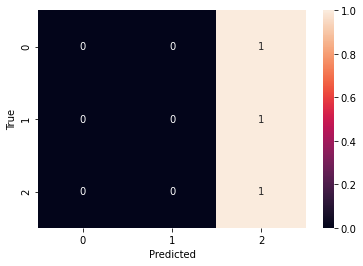

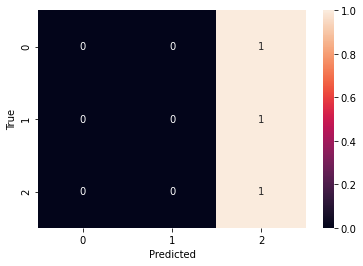

In [26]:
with mlflow.start_run(run_name='Figures'):
    for idx, x in enumerate(cms):
        fig, ax = plt.subplots()
        cm = x.confusion_matrix / x.confusion_matrix.numpy().sum(axis=1)[:, tf.newaxis]
        sns.heatmap(cm, annot=True, ax=ax)
        plt.xlabel("Predicted")
        plt.ylabel("True")
        
        mlflow.log_figure(fig, f'heatmap_{idx}.png')

In [5]:
test_data = generate_data()

In [10]:
ls = list(test_data.map(lambda x, y: y))

In [12]:
test_tensor = tf.concat(ls, axis=0)

In [18]:
tf.reshape(test_tensor, (-1,))

<tf.Tensor: shape=(300,), dtype=int32, numpy=
array([2, 1, 2, 0, 1, 0, 0, 2, 2, 0, 1, 1, 1, 1, 2, 0, 1, 0, 0, 0, 2, 2,
       0, 0, 1, 2, 1, 2, 0, 0, 0, 2, 2, 0, 2, 1, 2, 2, 1, 2, 2, 0, 1, 1,
       0, 1, 1, 2, 0, 1, 2, 2, 0, 0, 1, 2, 2, 1, 2, 0, 0, 1, 0, 1, 0, 2,
       0, 1, 0, 0, 1, 2, 1, 1, 1, 2, 2, 0, 1, 0, 2, 0, 1, 2, 2, 2, 0, 2,
       2, 2, 0, 1, 2, 2, 1, 2, 0, 0, 0, 1, 1, 0, 1, 2, 0, 2, 0, 2, 1, 1,
       0, 0, 1, 1, 2, 1, 1, 2, 1, 2, 2, 1, 0, 0, 2, 2, 1, 1, 2, 2, 2, 0,
       2, 2, 2, 0, 2, 0, 2, 0, 1, 2, 0, 2, 2, 2, 0, 0, 1, 2, 2, 2, 0, 2,
       0, 1, 0, 0, 1, 2, 2, 1, 0, 0, 1, 0, 0, 1, 2, 1, 1, 2, 2, 0, 1, 0,
       0, 1, 0, 1, 2, 1, 2, 1, 2, 1, 0, 0, 0, 2, 0, 2, 0, 1, 0, 2, 0, 2,
       2, 2, 0, 2, 2, 0, 2, 1, 0, 0, 1, 1, 2, 0, 1, 2, 2, 0, 2, 2, 2, 0,
       2, 2, 1, 2, 2, 2, 1, 1, 1, 0, 1, 2, 1, 1, 0, 2, 1, 2, 1, 0, 2, 1,
       0, 2, 2, 0, 1, 2, 0, 0, 1, 0, 1, 1, 2, 2, 1, 1, 0, 1, 2, 0, 2, 0,
       2, 1, 0, 0, 1, 0, 2, 0, 0, 2, 0, 1, 0, 0, 0, 1, 2, 2, 2, 1, 0, 2,
     